In [1]:
%load_ext autoreload
%autoreload 2

# C++ to numba code

In [2]:
import numba,numpy as np,PyMKL,sak,sak.data,functools,tqdm

In [18]:
@numba.jit(numba.int32(numba.int32, numba.int32), nopython=True)
def f(x, y):
    # A somewhat trivial example
    return x + y


%timeit 2 + 5
%timeit f(2,5)

@numba.jit(numba.int32(numba.int32, numba.int32), nopython=False)
def f(x, y):
    # A somewhat trivial example
    return x + y

%timeit f(2,5)


7.67 ns ± 0.0325 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)
184 ns ± 0.984 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
184 ns ± 1.09 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [51]:
K = PyMKL.io.read_mkl_kernels("/home/guille/opt/mkl-mpi-bsc/data/Kbin")
D = PyMKL.io.read_mkl_binary("/home/guille/opt/mkl-mpi-bsc/data/Dbin",dtype="float64")
W = PyMKL.io.read_mkl_binary("/home/guille/opt/mkl-mpi-bsc/data/Wbin",dtype="float32")
M,N,N = K.shape
betas = np.ones((M, 1)) / M
D = np.diag(D.squeeze())
K = K.astype("float32")
D = D.astype("float32")
W = W.astype("float32")
betas = betas.astype("float32")


In [53]:
from joblib import Parallel
from joblib import delayed
from joblib.parallel import effective_n_jobs

K = K.astype("float32")
D = D.astype("float64")
W = W.astype("float32")

self = PyMKL.MKL(K,W,D)
# %%time

numWorkers      = effective_n_jobs()
values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
start_values    = values[0:-1]
end_values      = values[1:]

SW_betas        = np.zeros((self.N, self.N))
SD_betas        = np.zeros((self.N, self.N))

ParallelResult  = Parallel(n_jobs=numWorkers, prefer="threads")(delayed(PyMKL.lib.computeSWB)(np.moveaxis(self.K,0,-1),self.betas,self.W,np.diag(self.D),start_values[i],end_values[i]) for i in range(len(start_values)))    

for (SW_betastmp,SD_betastmp) in ParallelResult:
    SW_betas    = SW_betas + SW_betastmp
    SD_betas    = SD_betas + SD_betastmp

SW_betas            = SW_betas + np.triu(SW_betas,1).T
SD_betas            = SD_betas + np.triu(SD_betas,1).T


In [7]:
SW_betas = np.zeros((N, N))
SD_betas = np.zeros((N, N))
betas_T  = betas.T

for i in range(N):
    for j in range(N):
        if j <= i:
            continue
        Ki = K[:, i, :].transpose()
        Kj = K[:, j, :].transpose()
        SW_betas = SW_betas + W[i, j] * (Ki - Kj).dot(betas).dot(betas_T).dot(
            (Ki - Kj).transpose())
    SD_betas = SD_betas + D[i, i] * np.dot(np.dot(Ki, betas),np.dot(betas_T,Ki.T))

SW_betas            = SW_betas + np.triu(SW_betas,1).T
SD_betas            = SD_betas + np.triu(SD_betas,1).T


NameError: name 'kjasghkjgasd' is not defined

In [11]:
aaa = functools.reduce(np.dot,[Ki, betas, betas.transpose(), Ki.transpose()])

In [15]:
np.allclose(aaa,)

True

In [45]:
N = K.shape[-1]
SW_betas = np.zeros((N, N))
SD_betas = np.zeros((N, N))
betas_T  = betas.T

for i in range(N):
    Ki = K[:, i, :].T
    for j in range(N):
        if j <= i:
            continue
        Kj = K[:, j, :].T
        difference = (Ki - Kj)
        difference_squared = difference @ (betas @ betas_T) @ difference.T
        difference_weights = W[i, j] * difference_squared
        SW_betas = SW_betas + difference_weights

    ki_betas_squared = Ki @ (betas @ betas_T) @ Ki.T
    diagonal_ki = D[i, i] * ki_betas_squared
    SD_betas = SD_betas + diagonal_ki
    aghkjaghs

SW_betas            = SW_betas + np.triu(SW_betas,1).T
SD_betas            = SD_betas + np.triu(SD_betas,1).T


NameError: name 'aghkjaghs' is not defined

In [44]:
np.allclose(ki_betas_squared, )

True

In [37]:
np.allclose(ki_betas_squared, ki_betas @ ki_betas_T)

True

In [378]:
new_N = 127
K = PyMKL.io.read_mkl_kernels("/home/guille/opt/mkl-mpi-bsc/data/Kbin")
D = PyMKL.io.read_mkl_binary("/home/guille/opt/mkl-mpi-bsc/data/Dbin",dtype="float64")
W = PyMKL.io.read_mkl_binary("/home/guille/opt/mkl-mpi-bsc/data/Wbin",dtype="float32")

# Reduce size
K = K[:,:new_N,:new_N]
D = D[:new_N]
W = W[:new_N,:new_N]

# Get rest of variables
M,N,N = K.shape
betas = np.ones((M, 1)) / M
D = np.diag(D.squeeze())


# To contiguous
K = np.ascontiguousarray(K.astype("float32"))
D = np.ascontiguousarray(D.astype("float32"))
W = np.ascontiguousarray(W.astype("float32"))
betas = np.ascontiguousarray(betas.astype("float32"))

In [164]:
import numba,numpy as np,PyMKL,sak,sak.data,functools,tqdm

def compute_SWB(K, W, betas):
    # Copy as contiguous
    K       = np.ascontiguousarray(    K.astype("float32"))
    W       = np.ascontiguousarray(    W.astype("float32"))
    betas   = np.ascontiguousarray(betas.astype("float32"))
    betas_T = np.ascontiguousarray(betas.T)
    
    # Obtain output vectors
    N = K.shape[-1]
    SW_betas = np.zeros((N, N))
    SD_betas = np.zeros((N, N))
    
    # Iterate over vectors
    for i in range(N):
        Ki_T = np.ascontiguousarray(K[:, i, :])
        Ki   = np.ascontiguousarray(K[:, i, :].T)
        for j in range(N):
            if j <= i:
                continue
            Kj   = np.ascontiguousarray(K[:, j, :].T)
            difference   = (Ki - Kj)
            difference_T = np.ascontiguousarray(difference.T)
            difference_squared = difference @ (betas @ betas_T) @ difference_T
            difference_weights = W[i, j] * difference_squared
            SW_betas = SW_betas + difference_weights

        ki_betas_squared = Ki @ (betas @ betas_T) @ Ki_T
        diagonal_ki = D[i, i] * ki_betas_squared
        SD_betas = SD_betas + diagonal_ki

    SW_betas            = SW_betas + np.triu(SW_betas,1).T
    SD_betas            = SD_betas + np.triu(SD_betas,1).T
    
    return SW_betas, SD_betas

import numba,numpy as np,PyMKL,sak,sak.data,functools,tqdm

def compute_SWB_parallel(K, W, betas):
    # Copy as contiguous
    K       = np.ascontiguousarray(    K.astype("float32"))
    W       = np.ascontiguousarray(    W.astype("float32"))
    betas   = np.ascontiguousarray(betas.astype("float32"))
    betas_T = np.ascontiguousarray(betas.T)
    
    # Obtain output vectors
    N = K.shape[-1]
    SW_betas = np.zeros((N, N))
    SD_betas = np.zeros((N, N))
    
    # Counters
    product  = np.vstack(((np.arange(0,N**2,1)//N),(np.arange(0,N**2)%N))).T
    
    # Iterate over vectors
    for i,j in product:
        if j <= i:
            continue
        Ki_T = np.ascontiguousarray(K[:, i, :])
        Ki   = np.ascontiguousarray(K[:, i, :].T)
        Kj   = np.ascontiguousarray(K[:, j, :].T)
        difference   = (Ki - Kj)
        difference_T = np.ascontiguousarray(difference.T)
        difference_squared = difference @ (betas @ betas_T) @ difference_T
        difference_weights = W[i, j] * difference_squared
        SW_betas = SW_betas + difference_weights

        ki_betas_squared = Ki @ (betas @ betas_T) @ Ki_T
        diagonal_ki = D[i, i] * ki_betas_squared
        SD_betas = SD_betas + diagonal_ki

    SW_betas            = SW_betas + np.triu(SW_betas,1).T
    SD_betas            = SD_betas + np.triu(SD_betas,1).T
    
    return SW_betas, SD_betas

In [172]:
%%time
SW_betas_numba, SD_betas_numba = numba.jit(
    (numba.float32[:,:,:],numba.float32[:,:],numba.float32[:,:]), 
    nopython=True, parallel=True)(compute_SWB)(K,W,betas)

CPU times: user 3.57 s, sys: 18.2 ms, total: 3.59 s
Wall time: 2.78 s


In [143]:
from joblib import Parallel
from joblib import delayed
from joblib.parallel import effective_n_jobs

K = K.astype("float32")
D = D.astype("float64")
W = W.astype("float32")

self = PyMKL.MKL(K,W,D)

In [152]:
%%time

from joblib import Parallel
from joblib import delayed
from joblib.parallel import effective_n_jobs

K = K.astype("float32")
D = D.astype("float64")
W = W.astype("float32")

self = PyMKL.MKL(K,W,D)

numWorkers      = effective_n_jobs()
values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
start_values    = values[0:-1]
end_values      = values[1:]

SW_betas        = np.zeros((self.N, self.N))
SD_betas        = np.zeros((self.N, self.N))

ParallelResult  = Parallel(n_jobs=numWorkers, prefer="threads")(delayed(PyMKL.lib.computeSWB)(np.moveaxis(self.K,0,-1),self.betas,self.W,np.diag(self.D),start_values[i],end_values[i]) for i in range(len(start_values)))    

for (SW_betastmp,SD_betastmp) in ParallelResult:
    SW_betas    = SW_betas + SW_betastmp
    SD_betas    = SD_betas + SD_betastmp

SW_betas        = SW_betas + np.triu(SW_betas,1).T
SD_betas        = SD_betas + np.triu(SD_betas,1).T


CPU times: user 29 ms, sys: 3.81 ms, total: 32.8 ms
Wall time: 24.7 ms


In [374]:
def computeSWB_c(K: np.ndarray, W: np.ndarray, D: np.ndarray, betas: np.ndarray, i1: int, i2: int):
    M,N,N = K.shape
    
    tmp      = np.zeros((N,))
    SW_betas = np.zeros((N, N))
    SD_betas = np.zeros((N, N))
    
    for i in range(i1,i2):
        for j in range(i+1,N):
            Wij = W[i,j]
            
            if Wij != 0:
                for r in range(N):
                    tmpV = np.float32(0.0)
                    
                    for c in range(M):
                        tmpV += (K[c,i,r] - K[c,j,r]) * betas[c,0]
                        
                    tmp[r] = tmpV
                
                for r in range(N):
                    for l in range(r,N):
                        SW_betas[r,l] += 2*Wij * (tmp[r] * tmp[l])
        
        for r in range(N):
            tmpV = np.float32(0.0)
            for c in range(0,M):
                tmpV += K[c,i,r] * betas[c,0]
            
            tmp[r] = tmpV
            
        for r in range(N):
            for l in range(r,N):
                SD_betas[r,l] += D[i,i] * (tmp[r] * tmp[l])
                
    return SW_betas, SD_betas

def computeSWB_c_2(K: np.ndarray, W: np.ndarray, D: np.ndarray, betas: np.ndarray):
    M,N,N = K.shape
    
    tmp      = np.zeros((N,))
    SW_betas = np.zeros((N, N))
    SD_betas = np.zeros((N, N))
    
    for i in range(N):
        for j in range(i+1,N):
            Wij = W[i,j]
            
            if Wij != 0:
                for r in range(N):
                    tmpV = np.float32(0.0)
                    
                    for c in range(M):
                        tmpV += (K[c,i,r] - K[c,j,r]) * betas[c,0]
                        
                    tmp[r] = tmpV
                
                for r in range(N):
                    for l in range(r,N):
                        SW_betas[r,l] += 2*Wij * (tmp[r] * tmp[l])
        
        for r in range(N):
            tmpV = np.float32(0.0)
            for c in range(0,M):
                tmpV += K[c,i,r] * betas[c,0]
            
            tmp[r] = tmpV
            
        for r in range(N):
            for l in range(r,N):
                SD_betas[r,l] += D[i,i] * (tmp[r] * tmp[l])
                
    return SW_betas, SD_betas


In [ ]:
def product_range(N, iterators: int = 2):
    index = 0
    while index < N**iterators:
        yield tuple([index//(N**(iterators-j-1)) if j != iterators-1 else index%N for j in range(iterators)])
        index += 1


In [219]:
%%time
SW_betas_c,SD_betas_c = computeSWB_c(K,W,D,betas,0,N)

CPU times: user 15.3 s, sys: 3.71 ms, total: 15.3 s
Wall time: 15.3 s


In [208]:
%%time
SW_betas_c,SD_betas_c = computeSWB_parallel(K,W,D,betas)

CPU times: user 15.2 s, sys: 53.1 ms, total: 15.3 s
Wall time: 15.3 s


In [317]:
%%time
SW_betas_c_parallel, SD_betas_parallel = numba.jit(
    (numba.float32[:,:,:],numba.float32[:,:],numba.float32[:,:],numba.float32[:,:],numba.int64,numba.int64), 
    nopython=True, parallel=True)(computeSWB_c)(K,W,D,betas,0,N)

CPU times: user 822 ms, sys: 3.91 ms, total: 826 ms
Wall time: 790 ms


In [318]:
%%time
SW_betas_c_parallel_2, SD_betas_parallel_2 = numba.jit(
    (numba.float32[:,:,:],numba.float32[:,:],numba.float32[:,:],numba.float32[:,:]), 
    nopython=True, parallel=True)(computeSWB_c_2)(K,W,D,betas)

CPU times: user 828 ms, sys: 367 µs, total: 828 ms
Wall time: 793 ms


In [616]:
from numba import *

In [620]:
K_tot_all = np.moveaxis(K,0,-1)

In [631]:
# %%time

@jit((float32[:,:,:],float32[:,:],float32[:,:],float32[:,:]), nopython=True, parallel=True)
def computeSWB_c_3(K_tot_all: np.ndarray, W: np.ndarray, D: np.ndarray, betas: np.ndarray):
    N,N,M = K_tot_all.shape
    
    tmp      = np.zeros((N,))
    SW_betas = np.zeros((N, N))
    SD_betas = np.zeros((N, N))
    
    for i in range(N):
        for j in range(i+1,N):
            Wij = W[i,j]
            
            if Wij != 0:
                for r in range(N):
                    tmpV = np.float32(0.0)
                    for c in range(M):
                        tmpV += (K_tot_all[i,r,c] - K_tot_all[j,r,c]) * betas[c,0]
                    tmp[r] = tmpV
                
                for r in range(N):
                    for l in range(r,N):
                        tmpV = 2*Wij * (tmp[r] * tmp[l])
                        SW_betas[r,l] += tmpV
                        if r != l: SW_betas[l,r] += tmpV
        
        for r in range(N):
            tmpV = np.float32(0.0)
            for c in range(0,M):
                tmpV += K_tot_all[i,r,c] * betas[c,0]
            tmp[r] = tmpV
            
        for r in range(N):
            for l in range(r,N):
                tmpV = D[i,i] * (tmp[r] * tmp[l])
                SD_betas[r,l] += tmpV
                if r != l: SD_betas[l,r] += tmpV

    return (SW_betas, SD_betas)

out = computeSWB_c_3(K_tot_all,W,D,betas)

In [732]:
@jit((float64[:,:,:],float64[:,:],float64[:,:],float64[:],int64,int64), nopython=True, parallel=True)
def computeSWA(K_tot_all: np.ndarray, A: np.ndarray, W: np.ndarray, Diag: np.ndarray, i1, i2):
    N,N,M = K_tot_all.shape
    NA    = A.shape[1]
    
    tmp      = np.zeros((M,NA))
    KiA      = np.zeros((N,M,NA))
    SWA = np.zeros((M, M))
    SDA = np.zeros((M, M))

    for i in range(N):
        for c in range(M):
            for r in range(NA):
                tmpV = np.float64(0.0)
                for l in range(N):
                    tmpV += K_tot_all[i,l,c] * A[l,r]
                KiA[i,c,r] = tmpV

    for i in range(N):
        for j in range(i+1,N):
            Wij = W[i,j]
            if Wij != 0:
                for c1 in range(M):
                    for c2 in range(c1,M):
                        tmpV = np.float64(0.0)
                        for k in range(NA):
                            tmp1  = KiA[i,c1,k] - KiA[j,c1,k]
                            tmp2  = KiA[i,c2,k] - KiA[j,c2,k]
                            tmpV += tmp1 * tmp2
                        SWA[c1,c2] += 2.0 * Wij * tmpV
        
        for c in range(M):
            for r in range(NA):
                tmpV = np.float64(0.0)
                for l in range(N):
                    tmpV += K_tot_all[i,l,c] * A[l,r]
                tmp[c,r] = tmpV
        
        for c1 in range(M):
            for c2 in range(c1,M):
                tmpV = np.float64(0.0)
                for k in range(NA):
                    tmpV += tmp[c1,k] * tmp[c2,k]
                SDA[c1,c2] += Diag[i] * tmpV
                
    return np.ascontiguousarray(SWA), np.ascontiguousarray(SDA)


@jit((float64[:,:,:],float64[:,:],float64[:,:],float64[:],int64,int64), nopython=True, parallel=True)
def computeSWB(K_tot_all: np.ndarray, betas: np.ndarray, W: np.ndarray, Diag: np.ndarray, i1, i2):
    N,N,M = K_tot_all.shape
    
    tmp      = np.zeros((N,))
    SW_betas = np.zeros((N, N))
    SD_betas = np.zeros((N, N))
    
    for i in range(N):
        for j in range(i+1,N):
            Wij = W[i,j]
            
            if Wij != 0:
                for r in range(N):
                    tmpV = np.float64(0.0)
                    for c in range(M):
                        tmpV += (K_tot_all[i,r,c] - K_tot_all[j,r,c]) * betas[c,0]
                    tmp[r] = tmpV
                
                for r in range(N):
                    for l in range(r,N):
                        SW_betas[r,l] += 2*Wij * (tmp[r] * tmp[l])
        
        for r in range(N):
            tmpV = np.float64(0.0)
            for c in range(0,M):
                tmpV += K_tot_all[i,r,c] * betas[c,0]
            tmp[r] = tmpV
            
        for r in range(N):
            for l in range(r,N):
                SD_betas[r,l] += Diag[i] * (tmp[r] * tmp[l])
                
    return np.ascontiguousarray(SW_betas), np.ascontiguousarray(SD_betas)


@jit((float64[:,:,:],float64[:,:],float64[:,:],float64[:,:],float64[:],int64,int64), nopython=True, parallel=True)
def computeENERGY(K_tot_all: np.ndarray, betas: np.ndarray, A: np.ndarray, W: np.ndarray, Diag: np.ndarray, i1, i2):
    N,N,M = K_tot_all.shape
    NA    = A.shape[1]
    
    tmp    = np.zeros((NA))
    tmpM   = np.zeros((N,N))
    gap    = np.float64(0.0)
    constr = np.float64(0.0)

    for i in range(N):
        for r in range(N):
            tmpV = np.float64(0.0)
            for c in range(M):
                tmpV += K_tot_all[i,r,c] * betas[c,0]
            tmpM[i,r] = tmpV

    for i in range(N):
        for j in range(i+1,N):
            Wij = W[i,j]
            if Wij != 0:
                for r in range(NA):
                    tmpV = np.float64(0.0)
                    for l in range(N):
                        tmpV += A[l,r] * (tmpM[i,l] - tmpM[j,l])
                    tmp[r] = tmpV

                gapij = np.float64(0.0)
                for r in range(NA):
                    gapij += tmp[r]**2
                gap += 2.0 * gapij * Wij

        for r in range(NA):
            tmpV = np.float64(0.0)
            for l in range(N):
                tmpV += A[l,r] * tmpM[i,l]
            tmp[r] = tmpV

        constrii = np.float64(0.0)
        for r in range(NA):
            constrii += tmp[r]**2
        constr += Diag[i] * constrii
                
    return gap,constr


In [718]:
%%time

from joblib import Parallel
from joblib import delayed
from joblib.parallel import effective_n_jobs

K = K.astype("float32")
D = D.astype("float64")
W = W.astype("float32")

self = PyMKL.MKL(K,W,D)

# compute sides of GEP

try:
    numWorkers      = effective_n_jobs()
    values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
    start_values    = values[0:-1]
    end_values      = values[1:]

    SW_betas_cpp        = np.zeros((self.N, self.N))
    SD_betas_cpp        = np.zeros((self.N, self.N))

    ParallelResult  = Parallel(n_jobs=numWorkers, prefer="threads")(delayed(PyMKL.lib.computeSWB)(np.moveaxis(self.K,0,-1),self.betas,self.W,np.diag(self.D),start_values[i],end_values[i]) for i in range(len(start_values)))    

    for (SW_betastmp,SD_betastmp) in ParallelResult:
        SW_betas_cpp    = SW_betas_cpp + SW_betastmp
        SD_betas_cpp    = SD_betas_cpp + SD_betastmp
except NameError:
    (SW_betas_cpp,SD_betas_cpp) = PyMKL.lib.computeSWB(np.moveaxis(self.K,0,-1),self.betas,self.W,np.diag(self.D).copy(),0,self.N)
except KeyboardInterrupt:
    raise

SW_betas_cpp            = SW_betas_cpp + np.triu(SW_betas_cpp,1).T
SD_betas_cpp            = SD_betas_cpp + np.triu(SD_betas_cpp,1).T

## TRANSFORM THE MATRICES TO POSITIVE DEFINITE ##
SW_betas_cpp            = np.real(PyMKL.lib.to_PDM(SW_betas_cpp, self.eps)) + self.eps*np.eye(self.N)
SD_betas_cpp            = np.real(PyMKL.lib.to_PDM(SD_betas_cpp, self.eps)) + self.eps*np.eye(self.N)

# Avoid numerical errors
SW_betas_cpp            = 0.5*(SW_betas_cpp + SW_betas_cpp.T)
SD_betas_cpp            = 0.5*(SD_betas_cpp + SD_betas_cpp.T)

if np.allclose(np.matrix(SW_betas_cpp),np.matrix(SW_betas_cpp).H):
    # If is Hermitian, perform scipy's eigh (WAY faster)
    eigvals, A      = sp.linalg.eigh(SW_betas_cpp, b=SD_betas_cpp)
else:
    # Else, compute scipy's eig
    eigvals, A      = sp.linalg.eig(SW_betas_cpp,  b=SD_betas_cpp)

A                   = np.real(A)
eigvals             = np.real(eigvals)
A                   = A[:,(eigvals > self.eps).ravel()]
eigvals             = eigvals[(eigvals > self.eps).ravel()]

# Normalization to comply with original MATLAB code
A                   = np.divide(A,np.linalg.norm(A,axis=0))

self.A              = A
self.SW_betas_cpp       = SW_betas_cpp
self.SD_betas_cpp       = SD_betas_cpp


CPU times: user 60.4 ms, sys: 47.7 ms, total: 108 ms
Wall time: 35.8 ms


In [719]:
%%time

from joblib import Parallel
from joblib import delayed
from joblib.parallel import effective_n_jobs

K = K.astype("float32")
D = D.astype("float64")
W = W.astype("float32")

self = PyMKL.MKL(K,W,D)

# compute sides of GEP

numWorkers      = effective_n_jobs()
values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
start_values    = values[0:-1]
end_values      = values[1:]

SW_betas_nb        = np.zeros((self.N, self.N))
SD_betas_nb        = np.zeros((self.N, self.N))

SW_betas_nb,SD_betas_nb = computeSWB(np.moveaxis(self.K,0,-1),self.betas,self.W,np.diag(self.D).copy(),0,N)

SW_betas_nb            = SW_betas_nb + np.triu(SW_betas_nb,1).T
SD_betas_nb            = SD_betas_nb + np.triu(SD_betas_nb,1).T

## TRANSFORM THE MATRICES TO POSITIVE DEFINITE ##
SW_betas_nb            = np.real(PyMKL.lib.to_PDM(SW_betas_nb, self.eps)) + self.eps*np.eye(self.N)
SD_betas_nb            = np.real(PyMKL.lib.to_PDM(SD_betas_nb, self.eps)) + self.eps*np.eye(self.N)

# Avoid numerical errors
SW_betas_nb            = 0.5*(SW_betas_nb + SW_betas_nb.T)
SD_betas_nb            = 0.5*(SD_betas_nb + SD_betas_nb.T)

if np.allclose(np.matrix(SW_betas_nb),np.matrix(SW_betas_nb).H):
    # If is Hermitian, perform scipy's eigh (WAY faster)
    eigvals, A      = sp.linalg.eigh(SW_betas_nb, b=SD_betas_nb)
else:
    # Else, compute scipy's eig
    eigvals, A      = sp.linalg.eig(SW_betas_nb,  b=SD_betas_nb)

A                   = np.real(A)
eigvals             = np.real(eigvals)
A                   = A[:,(eigvals > self.eps).ravel()]
eigvals             = eigvals[(eigvals > self.eps).ravel()]

# Normalization to comply with original MATLAB code
A                   = np.divide(A,np.linalg.norm(A,axis=0))

self.A              = A
self.SW_betas_nb       = SW_betas_nb
self.SD_betas_nb       = SD_betas_nb


CPU times: user 178 ms, sys: 100 ms, total: 278 ms
Wall time: 84.6 ms


In [720]:
np.allclose(SW_betas_cpp,SW_betas_nb),np.allclose(SD_betas_nb,SD_betas_cpp)

(True, True)

# COMPUTE SWA

In [712]:
%%time

from joblib import Parallel
from joblib import delayed
from joblib.parallel import effective_n_jobs

K = K.astype("float32")
D = D.astype("float64")
W = W.astype("float32")

self = PyMKL.MKL(K,W,D)

# compute sides of GEP

try:
    numWorkers      = effective_n_jobs()
    values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
    start_values    = values[0:-1]
    end_values      = values[1:]

    SW_betas        = np.zeros((self.N, self.N))
    SD_betas        = np.zeros((self.N, self.N))

    ParallelResult  = Parallel(n_jobs=numWorkers, prefer="threads")(delayed(PyMKL.lib.computeSWB)(np.moveaxis(self.K,0,-1),self.betas,self.W,np.diag(self.D),start_values[i],end_values[i]) for i in range(len(start_values)))    

    for (SW_betastmp,SD_betastmp) in ParallelResult:
        SW_betas    = SW_betas + SW_betastmp
        SD_betas    = SD_betas + SD_betastmp
except NameError:
    (SW_betas,SD_betas) = PyMKL.lib.computeSWB(np.moveaxis(self.K,0,-1),self.betas,self.W,np.diag(self.D).copy(),0,self.N)
except KeyboardInterrupt:
    raise

SW_betas            = SW_betas + np.triu(SW_betas,1).T
SD_betas            = SD_betas + np.triu(SD_betas,1).T

## TRANSFORM THE MATRICES TO POSITIVE DEFINITE ##
SW_betas            = np.real(PyMKL.lib.to_PDM(SW_betas, self.eps)) + self.eps*np.eye(self.N)
SD_betas            = np.real(PyMKL.lib.to_PDM(SD_betas, self.eps)) + self.eps*np.eye(self.N)

# Avoid numerical errors
SW_betas            = 0.5*(SW_betas + SW_betas.T)
SD_betas            = 0.5*(SD_betas + SD_betas.T)

if np.allclose(np.matrix(SW_betas),np.matrix(SW_betas).H):
    # If is Hermitian, perform scipy's eigh (WAY faster)
    eigvals, A      = sp.linalg.eigh(SW_betas, b=SD_betas)
else:
    # Else, compute scipy's eig
    eigvals, A      = sp.linalg.eig(SW_betas,  b=SD_betas)

A                   = np.real(A)
eigvals             = np.real(eigvals)
A                   = A[:,(eigvals > self.eps).ravel()]
eigvals             = eigvals[(eigvals > self.eps).ravel()]

# Normalization to comply with original MATLAB code
A                   = np.divide(A,np.linalg.norm(A,axis=0))

self.A              = A
self.SW_betas       = SW_betas
self.SD_betas       = SD_betas

# Use C compiled code
try:
    numWorkers      = effective_n_jobs()
    values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
    start_values    = values[0:-1]
    end_values      = values[1:]

    SW_A_cpp            = np.zeros((self.M, self.M))
    SD_A_cpp            = np.zeros((self.M, self.M))

    ParallelResult  = Parallel(n_jobs=numWorkers, prefer="threads")(delayed(PyMKL.lib.computeSWA)(np.moveaxis(self.K,0,-1),self.A,self.W,np.diag(self.D),start_values[i],end_values[i]) for i in range(len(start_values)))    

    for (SW_A_cpptmp,SD_A_cpptmp) in ParallelResult:
        SW_A_cpp        = SW_A_cpp + SW_A_cpptmp
        SD_A_cpp        = SD_A_cpp + SD_A_cpptmp
except NameError:
    (SW_A_cpp,SD_A_cpp)     = PyMKL.lib.computeSWA(np.moveaxis(self.K,0,-1),self.A,self.W,np.diag(self.D),0,self.N)
except KeyboardInterrupt:
    raise

# Solve solution throwing double the result in C compiled code
SW_A_cpp                = (SW_A_cpp + np.triu(SW_A_cpp,1).T)
SD_A_cpp                = (SD_A_cpp + np.triu(SD_A_cpp,1).T)

SW_A_cpp                = 0.5 * (SW_A_cpp + SW_A_cpp.T)
SD_A_cpp                = 0.5 * (SD_A_cpp + SD_A_cpp.T)

self.SW_A_cpp           = SW_A_cpp
self.SD_A_cpp           = SD_A_cpp


CPU times: user 286 ms, sys: 156 ms, total: 441 ms
Wall time: 138 ms


In [713]:
%%time

from joblib import Parallel
from joblib import delayed
from joblib.parallel import effective_n_jobs

K = K.astype("float32")
D = D.astype("float64")
W = W.astype("float32")

self = PyMKL.MKL(K,W,D)

# compute sides of GEP

try:
    numWorkers      = effective_n_jobs()
    values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
    start_values    = values[0:-1]
    end_values      = values[1:]

    SW_betas        = np.zeros((self.N, self.N))
    SD_betas        = np.zeros((self.N, self.N))

    ParallelResult  = Parallel(n_jobs=numWorkers, prefer="threads")(delayed(PyMKL.lib.computeSWB)(np.moveaxis(self.K,0,-1),self.betas,self.W,np.diag(self.D),start_values[i],end_values[i]) for i in range(len(start_values)))    

    for (SW_betastmp,SD_betastmp) in ParallelResult:
        SW_betas    = SW_betas + SW_betastmp
        SD_betas    = SD_betas + SD_betastmp
except NameError:
    (SW_betas,SD_betas) = PyMKL.lib.computeSWB(np.moveaxis(self.K,0,-1),self.betas,self.W,np.diag(self.D).copy(),0,self.N)
except KeyboardInterrupt:
    raise

SW_betas            = SW_betas + np.triu(SW_betas,1).T
SD_betas            = SD_betas + np.triu(SD_betas,1).T

## TRANSFORM THE MATRICES TO POSITIVE DEFINITE ##
SW_betas            = np.real(PyMKL.lib.to_PDM(SW_betas, self.eps)) + self.eps*np.eye(self.N)
SD_betas            = np.real(PyMKL.lib.to_PDM(SD_betas, self.eps)) + self.eps*np.eye(self.N)

# Avoid numerical errors
SW_betas            = 0.5*(SW_betas + SW_betas.T)
SD_betas            = 0.5*(SD_betas + SD_betas.T)

if np.allclose(np.matrix(SW_betas),np.matrix(SW_betas).H):
    # If is Hermitian, perform scipy's eigh (WAY faster)
    eigvals, A      = sp.linalg.eigh(SW_betas, b=SD_betas)
else:
    # Else, compute scipy's eig
    eigvals, A      = sp.linalg.eig(SW_betas,  b=SD_betas)

A                   = np.real(A)
eigvals             = np.real(eigvals)
A                   = A[:,(eigvals > self.eps).ravel()]
eigvals             = eigvals[(eigvals > self.eps).ravel()]

# Normalization to comply with original MATLAB code
A                   = np.divide(A,np.linalg.norm(A,axis=0))

self.A              = A
self.SW_betas       = SW_betas
self.SD_betas       = SD_betas

# Use C compiled code
try:
    numWorkers      = effective_n_jobs()
    values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
    start_values    = values[0:-1]
    end_values      = values[1:]

    SW_A_nb,SD_A_nb = computeSWA(np.moveaxis(self.K,0,-1),self.A,self.W,np.diag(self.D).copy(),0,N)
except:
    raise

# Solve solution throwing double the result in C compiled code
SW_A_nb                = (SW_A_nb + np.triu(SW_A_nb,1).T)
SD_A_nb                = (SD_A_nb + np.triu(SD_A_nb,1).T)

SW_A_nb                = 0.5 * (SW_A_nb + SW_A_nb.T)
SD_A_nb                = 0.5 * (SD_A_nb + SD_A_nb.T)

self.SW_A_nb           = SW_A_nb
self.SD_A_nb           = SD_A_nb


CPU times: user 388 ms, sys: 133 ms, total: 520 ms
Wall time: 200 ms


In [741]:
from setuptools import setup

In [ ]:
setup()

In [716]:
np.allclose(SW_A_cpp,SW_A_nb),np.allclose(SD_A_cpp,SD_A_nb)

(True, True)

# COMPUTE ENERGY

In [733]:
import numpy as np
import picos as pic
import warnings
import tqdm
from scipy.linalg import eig
from scipy.linalg import eigh
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from cvxopt import matrix


In [734]:
%%time

from joblib import Parallel
from joblib import delayed
from joblib.parallel import effective_n_jobs

K = K.astype("float32")
D = D.astype("float64")
W = W.astype("float32")

self = PyMKL.MKL(K,W,D,solver="smcp")

# compute sides of GEP

try:
    numWorkers      = effective_n_jobs()
    values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
    start_values    = values[0:-1]
    end_values      = values[1:]

    SW_betas        = np.zeros((self.N, self.N))
    SD_betas        = np.zeros((self.N, self.N))

    ParallelResult  = Parallel(n_jobs=numWorkers, prefer="threads")(delayed(PyMKL.lib.computeSWB)(np.moveaxis(self.K,0,-1),self.betas,self.W,np.diag(self.D),start_values[i],end_values[i]) for i in range(len(start_values)))    

    for (SW_betastmp,SD_betastmp) in ParallelResult:
        SW_betas    = SW_betas + SW_betastmp
        SD_betas    = SD_betas + SD_betastmp
except NameError:
    (SW_betas,SD_betas) = PyMKL.lib.computeSWB(np.moveaxis(self.K,0,-1),self.betas,self.W,np.diag(self.D).copy(),0,self.N)
except KeyboardInterrupt:
    raise

SW_betas            = SW_betas + np.triu(SW_betas,1).T
SD_betas            = SD_betas + np.triu(SD_betas,1).T

## TRANSFORM THE MATRICES TO POSITIVE DEFINITE ##
SW_betas            = np.real(PyMKL.lib.to_PDM(SW_betas, self.eps)) + self.eps*np.eye(self.N)
SD_betas            = np.real(PyMKL.lib.to_PDM(SD_betas, self.eps)) + self.eps*np.eye(self.N)

# Avoid numerical errors
SW_betas            = 0.5*(SW_betas + SW_betas.T)
SD_betas            = 0.5*(SD_betas + SD_betas.T)

if np.allclose(np.matrix(SW_betas),np.matrix(SW_betas).H):
    # If is Hermitian, perform scipy's eigh (WAY faster)
    eigvals, A      = sp.linalg.eigh(SW_betas, b=SD_betas)
else:
    # Else, compute scipy's eig
    eigvals, A      = sp.linalg.eig(SW_betas,  b=SD_betas)

A                   = np.real(A)
eigvals             = np.real(eigvals)
A                   = A[:,(eigvals > self.eps).ravel()]
eigvals             = eigvals[(eigvals > self.eps).ravel()]

# Normalization to comply with original MATLAB code
A                   = np.divide(A,np.linalg.norm(A,axis=0))

self.A              = A
self.SW_betas       = SW_betas
self.SD_betas       = SD_betas

# Use C compiled code
try:
    numWorkers      = effective_n_jobs()
    values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
    start_values    = values[0:-1]
    end_values      = values[1:]

    SW_A            = np.zeros((self.M, self.M))
    SD_A            = np.zeros((self.M, self.M))

    ParallelResult  = Parallel(n_jobs=numWorkers, prefer="threads")(delayed(PyMKL.lib.computeSWA)(np.moveaxis(self.K,0,-1),self.A,self.W,np.diag(self.D),start_values[i],end_values[i]) for i in range(len(start_values)))    

    for (SW_Atmp,SD_Atmp) in ParallelResult:
        SW_A        = SW_A + SW_Atmp
        SD_A        = SD_A + SD_Atmp
except NameError:
    (SW_A,SD_A)     = PyMKL.lib.computeSWA(np.moveaxis(self.K,0,-1),self.A,self.W,np.diag(self.D),0,self.N)
except KeyboardInterrupt:
    raise

# Solve solution throwing double the result in C compiled code
SW_A                = (SW_A + np.triu(SW_A,1).T)
SD_A                = (SD_A + np.triu(SD_A,1).T)

SW_A                = 0.5 * (SW_A + SW_A.T)
SD_A                = 0.5 * (SD_A + SD_A.T)

self.SW_A           = SW_A
self.SD_A           = SD_A

sdp                 = pic.Problem()
B                   = sdp.add_variable('B',(self.M,self.M),vtype='symmetric')
betas               = sdp.add_variable('betas',(self.M,1))
sdp.set_objective('min','I'|matrix(self.SW_A)*B)
sdp.add_constraint('I'|matrix(self.SD_A)*B >= 0)
sdp.add_constraint(betas >= 0)
# sdp.add_constraint(pic.sum([betas[i] for i in range(self.M)],'i','0...'+str(self.M)) == 1)
sdp.add_constraint(((1 & betas.T) // (betas & B))>>0 )

sdp.solve(solver=self.solver, solve_via_dual=False, verbose=False)

betas               = np.array(betas.value)
betas               = betas/np.sum(betas)

self.betas          = betas

try:
    numWorkers      = effective_n_jobs()
    values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
    start_values    = values[0:-1]
    end_values      = values[1:]

    gap_cpp             = 0
    constr_cpp          = 0

    ParallelResult = Parallel(n_jobs=numWorkers, prefer="threads")(delayed(PyMKL.lib.computeENERGY)(np.moveaxis(self.K,0,-1), self.betas, self.A, self.W, np.diag(self.D), start_values[i],end_values[i]) for i in range(len(start_values)))

    for (gap_cpptmp,constr_cpptmp) in ParallelResult:
        gap_cpp         = gap_cpp    + gap_cpptmp
        constr_cpp      = constr_cpp + constr_cpptmp

    gap_cpp             = gap_cpp
    constr_cpp          = constr_cpp
except NameError:
    (gap_cpp, constr_cpp)   = PyMKL.lib.computeENERGY(np.moveaxis(self.K,0,-1), self.betas, self.A, self.W, np.diag(self.D), 0, self.N)
except KeyboardInterrupt:
    raise

# Store energy
self.energy_cpp = [gap_cpp]
self.constr_cpp = [constr_cpp]


<timed exec>:93: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
<timed exec>:94: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
<timed exec>:101: DeprecationWarning: Option 'solve_via_dual' is deprecated, use 'dualize'.
<timed exec>:101: DeprecationWarning: Option 'verbose' is deprecated, use 'verbosity'.


CPU times: user 14.1 s, sys: 10.9 s, total: 24.9 s
Wall time: 6.91 s


In [735]:
%%time

from joblib import Parallel
from joblib import delayed
from joblib.parallel import effective_n_jobs

K = K.astype("float32")
D = D.astype("float64")
W = W.astype("float32")

self = PyMKL.MKL(K,W,D, solver="smcp")

# compute sides of GEP

try:
    numWorkers      = effective_n_jobs()
    values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
    start_values    = values[0:-1]
    end_values      = values[1:]

    SW_betas        = np.zeros((self.N, self.N))
    SD_betas        = np.zeros((self.N, self.N))

    ParallelResult  = Parallel(n_jobs=numWorkers, prefer="threads")(delayed(PyMKL.lib.computeSWB)(np.moveaxis(self.K,0,-1),self.betas,self.W,np.diag(self.D),start_values[i],end_values[i]) for i in range(len(start_values)))    

    for (SW_betastmp,SD_betastmp) in ParallelResult:
        SW_betas    = SW_betas + SW_betastmp
        SD_betas    = SD_betas + SD_betastmp
except NameError:
    (SW_betas,SD_betas) = PyMKL.lib.computeSWB(np.moveaxis(self.K,0,-1),self.betas,self.W,np.diag(self.D).copy(),0,self.N)
except KeyboardInterrupt:
    raise

SW_betas            = SW_betas + np.triu(SW_betas,1).T
SD_betas            = SD_betas + np.triu(SD_betas,1).T

## TRANSFORM THE MATRICES TO POSITIVE DEFINITE ##
SW_betas            = np.real(PyMKL.lib.to_PDM(SW_betas, self.eps)) + self.eps*np.eye(self.N)
SD_betas            = np.real(PyMKL.lib.to_PDM(SD_betas, self.eps)) + self.eps*np.eye(self.N)

# Avoid numerical errors
SW_betas            = 0.5*(SW_betas + SW_betas.T)
SD_betas            = 0.5*(SD_betas + SD_betas.T)

if np.allclose(np.matrix(SW_betas),np.matrix(SW_betas).H):
    # If is Hermitian, perform scipy's eigh (WAY faster)
    eigvals, A      = sp.linalg.eigh(SW_betas, b=SD_betas)
else:
    # Else, compute scipy's eig
    eigvals, A      = sp.linalg.eig(SW_betas,  b=SD_betas)

A                   = np.real(A)
eigvals             = np.real(eigvals)
A                   = A[:,(eigvals > self.eps).ravel()]
eigvals             = eigvals[(eigvals > self.eps).ravel()]

# Normalization to comply with original MATLAB code
A                   = np.divide(A,np.linalg.norm(A,axis=0))

self.A              = A
self.SW_betas       = SW_betas
self.SD_betas       = SD_betas

# Use C compiled code
try:
    numWorkers      = effective_n_jobs()
    values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
    start_values    = values[0:-1]
    end_values      = values[1:]

    SW_A            = np.zeros((self.M, self.M))
    SD_A            = np.zeros((self.M, self.M))

    ParallelResult  = Parallel(n_jobs=numWorkers, prefer="threads")(delayed(PyMKL.lib.computeSWA)(np.moveaxis(self.K,0,-1),self.A,self.W,np.diag(self.D),start_values[i],end_values[i]) for i in range(len(start_values)))    

    for (SW_Atmp,SD_Atmp) in ParallelResult:
        SW_A        = SW_A + SW_Atmp
        SD_A        = SD_A + SD_Atmp
except NameError:
    (SW_A,SD_A)     = PyMKL.lib.computeSWA(np.moveaxis(self.K,0,-1),self.A,self.W,np.diag(self.D),0,self.N)
except KeyboardInterrupt:
    raise

# Solve solution throwing double the result in C compiled code
SW_A                = (SW_A + np.triu(SW_A,1).T)
SD_A                = (SD_A + np.triu(SD_A,1).T)

SW_A                = 0.5 * (SW_A + SW_A.T)
SD_A                = 0.5 * (SD_A + SD_A.T)

self.SW_A           = SW_A
self.SD_A           = SD_A

sdp                 = pic.Problem()
B                   = sdp.add_variable('B',(self.M,self.M),vtype='symmetric')
betas               = sdp.add_variable('betas',(self.M,1))
sdp.set_objective('min','I'|matrix(self.SW_A)*B)
sdp.add_constraint('I'|matrix(self.SD_A)*B >= 0)
sdp.add_constraint(betas >= 0)
# sdp.add_constraint(pic.sum([betas[i] for i in range(self.M)],'i','0...'+str(self.M)) == 1)
sdp.add_constraint(((1 & betas.T) // (betas & B))>>0 )

sdp.solve(solver=self.solver, solve_via_dual=False, verbose=False)

betas               = np.array(betas.value)
betas               = betas/np.sum(betas)

self.betas          = betas

try:
    numWorkers      = effective_n_jobs()
    values          = PyMKL.lib.create_ivalues(numWorkers,self.N)
    start_values    = values[0:-1]
    end_values      = values[1:]

    gap_nb             = 0
    constr_nb          = 0

    ParallelResult = Parallel(n_jobs=numWorkers, prefer="threads")(delayed(PyMKL.lib.computeENERGY)(np.moveaxis(self.K,0,-1), self.betas, self.A, self.W, np.diag(self.D), start_values[i],end_values[i]) for i in range(len(start_values)))

    for (gap_nbtmp,constr_nbtmp) in ParallelResult:
        gap_nb         = gap_nb    + gap_nbtmp
        constr_nb      = constr_nb + constr_nbtmp

    gap_nb             = gap_nb
    constr_nb          = constr_nb
except NameError:
    (gap_nb, constr_nb)   = PyMKL.lib.computeENERGY(np.moveaxis(self.K,0,-1), self.betas, self.A, self.W, np.diag(self.D), 0, self.N)
except KeyboardInterrupt:
    raise

# Store energy
self.energy_nb = [gap_nb]
self.constr_nb = [constr_nb]


<timed exec>:93: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
<timed exec>:94: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
<timed exec>:101: DeprecationWarning: Option 'solve_via_dual' is deprecated, use 'dualize'.
<timed exec>:101: DeprecationWarning: Option 'verbose' is deprecated, use 'verbosity'.


CPU times: user 15 s, sys: 11.7 s, total: 26.8 s
Wall time: 7.27 s


In [738]:
np.allclose(gap_nb,gap_cpp),np.allclose(constr_nb,constr_cpp)

(True, True)

# Compile C++ code

In [4]:
import codecs
import os.path

from setuptools import setup, find_packages, Extension
from distutils.command.build_ext import build_ext as build_ext_orig

#  https://stackoverflow.com/questions/4529555/building-a-ctypes-based-c-library-with-distutils
class build_ext(build_ext_orig):
    def build_extension(self, ext):
        self._ctypes = isinstance(ext, Extension)
        return super().build_extension(ext)

    def get_export_symbols(self, ext):
        if self._ctypes:
            return ext.export_symbols
        return super().get_export_symbols(ext)

    def get_ext_filename(self, ext_name):
        if self._ctypes:
            return ext_name + '.so'
        return super().get_ext_filename(ext_name)

setup(
    py_modules = ["libPyMKL"],
    ext_modules=[
        Extension(
            "libPyMKL",
            ["lib/libPyMKL.c",],
        ),
    ],
    cmdclass={'build_ext': build_ext},
)



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3.8/distutils/fancy_getopt.py", line 233, in getopt
    opts, args = getopt.getopt(args, short_opts, self.long_opts)
  File "/usr/lib/python3.8/getopt.py", line 95, in getopt
    opts, args = do_shorts(opts, args[0][1:], shortopts, args[1:])
  File "/usr/lib/python3.8/getopt.py", line 195, in do_shorts
    if short_has_arg(opt, shortopts):
  File "/usr/lib/python3.8/getopt.py", line 211, in short_has_arg
    raise GetoptError(_('option -%s not recognized') % opt, opt)
getopt.GetoptError: option -f not recognized

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/distutils/core.py", line 134, in setup
    ok = dist.parse_command_line()
  File "/usr/lib/python3.8/distutils/dist.py", line 475, in parse_command_line
    args = parser.getopt(args=self.script_args, object=self)
  File "/usr/lib/python3.8/distutils/fancy_getopt.py", line 235, in getopt
   

TypeError: can only concatenate str (not "list") to str

In [ ]:
N = K.shape[-1]
SW_betas = zeros((self.N, self.N))
SD_betas = zeros((self.N, self.N))

for i in range(self.N):
    for j in range(self.N):
        Ki = self.K[:, i, :].transpose()
        Kj = self.K[:, j, :].transpose()
        SW_betas = SW_betas + self.sparse_W[i, j] * (Ki - Kj).dot(self.betas).dot(self.betas.transpose()).dot(
            (Ki - Kj).transpose())
    SD_betas = SD_betas + self.D[i, i] * reduce(dot,
                                                [Ki, self.betas, self.betas.transpose(), Ki.transpose()])

SW_betas            = SW_betas + np.triu(SW_betas,1).T
SD_betas            = SD_betas + np.triu(SD_betas,1).T


# Check execution on sample data

In [130]:
from __ops import MKL
import iotmp
import lib
import kernels
import analysis
import numpy as np
import scipy as sp
import scipy.io
import tqdm
import sak
import matplotlib.pyplot as plt

In [3]:
K = iotmp.read_mkl_kernels("/home/guille/opt/mkl-mpi-bsc/data/Kbin")
D = iotmp.read_mkl_binary("/home/guille/opt/mkl-mpi-bsc/data/Dbin",dtype="float64")
W = iotmp.read_mkl_binary("/home/guille/opt/mkl-mpi-bsc/data/Wbin",dtype="float32")

Iteration   6/ 25, Energy   0.024973 (< tolerance   0.029440; BREAK!):  20%|██        | 5/25 [00:38<02:33,  7.69s/it]


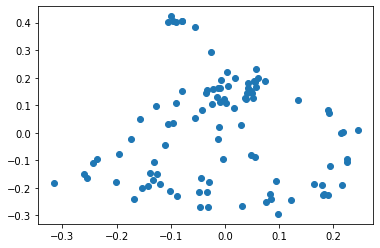

In [60]:
self_smcp = MKL(K,W,D,solver="smcp")

F_data_smcp = self_smcp.fit_transform()

plt.scatter(F_data_smcp[:,2],F_data_smcp[:,0])

In [63]:
# Linear combination of Kernels
Kernel = np.zeros(self_smcp.K.shape[1:]);
for i,(k,b) in enumerate(zip(self_smcp.K,self_smcp.betas)):
    Kernel += k*b

# Data projection into output space
if max(self_smcp.A.shape) > 1000:
    embedding = np.zeros_like(self_smcp.A)
    for i,k in enumerate(Kernel):
        embedding[i,] = k @ self_smcp.A
else:
    embedding = Kernel @ self_smcp.A
F_data_smcp = embedding.copy()

Iteration  25/ 25, Energy   0.627276 (> tolerance   0.021070): 100%|██████████| 25/25 [00:05<00:00,  4.22it/s]

Converged!


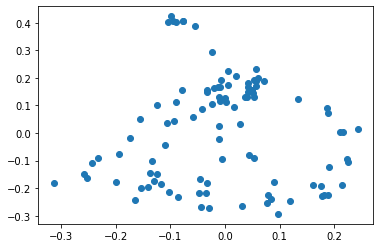

In [61]:
self_cvxopt = MKL(K,W,D,solver="cvxopt",maxiter=25,eps=1e-14)

F_data_cvxopt = self_cvxopt.fit_transform()

plt.scatter(F_data_cvxopt[:,2],F_data_cvxopt[:,0])

In [64]:
# Linear combination of Kernels
Kernel = np.zeros(self_cvxopt.K.shape[1:]);
for i,(k,b) in enumerate(zip(self_cvxopt.K,self_cvxopt.betas)):
    Kernel += k*b

# Data projection into output space
if max(self_cvxopt.A.shape) > 1000:
    embedding = np.zeros_like(self_cvxopt.A)
    for i,k in enumerate(Kernel):
        embedding[i,] = k @ self_cvxopt.A
else:
    embedding = Kernel @ self_cvxopt.A
F_data_cvxopt = embedding.copy()

In [52]:
A = iotmp.read_mkl_binary("/home/guille/opt/mkl-mpi-bsc/build/outputs/monitor/A",dtype="float64")
betas = iotmp.read_mkl_binary("/home/guille/opt/mkl-mpi-bsc/build/outputs/monitor/betas",dtype="float64")

# Linear combination of Kernels
Kernel = np.zeros(K.shape[1:]);
for i,(k,b) in enumerate(zip(K,betas)):
    Kernel += k*b

# Data projection into output space
if max(A.shape) > 1000:
    embedding = np.zeros_like(A)
    for i,k in enumerate(Kernel):
        embedding[i,] = k @ A
else:
    embedding = Kernel @ A
F_data_cpp = embedding.copy()

In [100]:
outputs_matlab = sp.io.loadmat("/home/guille/GitHub/SoO/Tools/UnsupervisedMKL/output.mat")
A_matlab = outputs_matlab["A"].astype(float)
betas_matlab = outputs_matlab["betas"].astype(float)

# Linear combination of Kernels
Kernel = np.zeros(K.shape[1:]);
for i,(k,b) in enumerate(zip(K,betas_matlab)):
    Kernel += k*b

# Data projection into output space
if max(A.shape) > 1000:
    embedding = np.zeros_like(A_matlab)
    for i,k in enumerate(Kernel):
        embedding[i,] = k @ A_matlab
else:
    embedding = Kernel @ A_matlab
F_data_matlab = -embedding.copy()

In [140]:
# Correct signs (!!!!!!!!!!!!!!!)
F_data_matlab *= np.round(np.array(sak.signal.xcorr(F_data_matlab,F_data_smcp,maxlags=0))[:,0,0])
F_data_cvxopt *= np.round(np.array(sak.signal.xcorr(F_data_cvxopt,F_data_smcp,maxlags=0))[:,0,0])

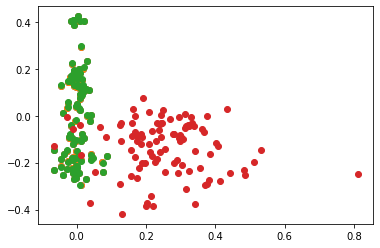

In [181]:
i,j = 77,0
plt.scatter(F_data_matlab[:,i],F_data_matlab[:,j])
plt.scatter(F_data_smcp[:,i],F_data_smcp[:,j])
plt.scatter(F_data_cvxopt[:,i],F_data_cvxopt[:,j])

plt.scatter(F_data_cpp[:,i],F_data_cpp[:,j])


# [2021/02/19] TRY OUT CVXPYLAYERS

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy
import scipy as sp
import scipy
import matplotlib.pyplot as plt
import scipy.io
# import MultipleKernelLearning

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# NUMBER OF FEATURES FOR PARALLELIZATION OF SWA

# CHECKING EVERYTHING AGAIN

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy
import scipy as sp
import scipy
import matplotlib.pyplot as plt
import scipy.io
import MultipleKernelLearning

OSError: no file with expected extension

In [9]:
loadData = scipy.io.loadmat('CONVERGENCE_ALL')

N = 1

InterpolatedBeats = loadData['InterpolatedBeats'][::N,:,:]
InterpolatedWvlts = loadData['InterpolatedWvlts'][::N,:,:,:]
FFT               = loadData['FFT'][::N,:,:]

del(loadData)

In [13]:
X = [FFT[:,0,:], 
     FFT[:,1,:], 
     FFT[:,2,:], 
     FFT[:,3,:], 
     FFT[:,4,:], 
     FFT[:,5,:], 
     FFT[:,6,:], 
     FFT[:,7,:],
     FFT[:,8,:], 
     FFT[:,9,:], 
     FFT[:,10,:], 
     FFT[:,11,:]]

# X = [InterpolatedBeats[:,0,:], 
#      InterpolatedBeats[:,1,:], 
#      InterpolatedBeats[:,2,:], 
#      InterpolatedBeats[:,3,:], 
#      InterpolatedBeats[:,4,:], 
#      InterpolatedBeats[:,5,:], 
#      InterpolatedBeats[:,6,:], 
#      InterpolatedBeats[:,7,:],
#      InterpolatedBeats[:,8,:], 
#      InterpolatedBeats[:,9,:], 
#      InterpolatedBeats[:,10,:], 
#      InterpolatedBeats[:,11,:]]



# X = [InterpolatedBeats[:,0,:], 
#      InterpolatedBeats[:,1,:], 
#      InterpolatedBeats[:,2,:], 
#      InterpolatedBeats[:,3,:], 
#      InterpolatedBeats[:,4,:], 
#      InterpolatedBeats[:,5,:], 
#      InterpolatedBeats[:,6,:], 
#      InterpolatedBeats[:,7,:],
#      InterpolatedBeats[:,8,:], 
#      InterpolatedBeats[:,9,:], 
#      InterpolatedBeats[:,10,:], 
#      InterpolatedBeats[:,11,:],
#      InterpolatedWvlts[:,0,0,:], 
#      InterpolatedWvlts[:,1,0,:], 
#      InterpolatedWvlts[:,2,0,:], 
#      InterpolatedWvlts[:,3,0,:], 
#      InterpolatedWvlts[:,4,0,:], 
#      InterpolatedWvlts[:,5,0,:], 
#      InterpolatedWvlts[:,6,0,:], 
#      InterpolatedWvlts[:,7,0,:],
#      InterpolatedWvlts[:,8,0,:], 
#      InterpolatedWvlts[:,9,0,:], 
#      InterpolatedWvlts[:,10,0,:], 
#      InterpolatedWvlts[:,11,0,:],
# #      InterpolatedWvlts[:,0,1,:], 
# #      InterpolatedWvlts[:,1,1,:], 
# #      InterpolatedWvlts[:,2,1,:], 
# #      InterpolatedWvlts[:,3,1,:], 
# #      InterpolatedWvlts[:,4,1,:], 
# #      InterpolatedWvlts[:,5,1,:], 
# #      InterpolatedWvlts[:,6,1,:], 
# #      InterpolatedWvlts[:,7,1,:],
# #      InterpolatedWvlts[:,8,1,:], 
# #      InterpolatedWvlts[:,9,1,:], 
# #      InterpolatedWvlts[:,10,1,:], 
# #      InterpolatedWvlts[:,11,1,:],
#      InterpolatedWvlts[:,0,2,:], 
#      InterpolatedWvlts[:,1,2,:], 
#      InterpolatedWvlts[:,2,2,:], 
#      InterpolatedWvlts[:,3,2,:], 
#      InterpolatedWvlts[:,4,2,:], 
#      InterpolatedWvlts[:,5,2,:], 
#      InterpolatedWvlts[:,6,2,:], 
#      InterpolatedWvlts[:,7,2,:],
#      InterpolatedWvlts[:,8,2,:], 
#      InterpolatedWvlts[:,9,2,:], 
#      InterpolatedWvlts[:,10,2,:], 
#      InterpolatedWvlts[:,11,2,:],
#      InterpolatedWvlts[:,0,3,:], 
#      InterpolatedWvlts[:,1,3,:], 
#      InterpolatedWvlts[:,2,3,:], 
#      InterpolatedWvlts[:,3,3,:], 
#      InterpolatedWvlts[:,4,3,:], 
#      InterpolatedWvlts[:,5,3,:], 
#      InterpolatedWvlts[:,6,3,:], 
#      InterpolatedWvlts[:,7,3,:],
#      InterpolatedWvlts[:,8,3,:], 
#      InterpolatedWvlts[:,9,3,:], 
#      InterpolatedWvlts[:,10,3,:], 
#      InterpolatedWvlts[:,11,3,:],
# #      InterpolatedWvlts[:,0,4,:], 
# #      InterpolatedWvlts[:,1,4,:], 
# #      InterpolatedWvlts[:,2,4,:], 
# #      InterpolatedWvlts[:,3,4,:], 
# #      InterpolatedWvlts[:,4,4,:], 
# #      InterpolatedWvlts[:,5,4,:], 
# #      InterpolatedWvlts[:,6,4,:], 
# #      InterpolatedWvlts[:,7,4,:],
# #      InterpolatedWvlts[:,8,4,:], 
# #      InterpolatedWvlts[:,9,4,:], 
# #      InterpolatedWvlts[:,10,4,:], 
# #      InterpolatedWvlts[:,11,4,:]]
#      FFT[:,0,:],
#      FFT[:,1,:],
#      FFT[:,2,:],
#      FFT[:,3,:],
#      FFT[:,4,:],
#      FFT[:,5,:],
#      FFT[:,6,:],
#      FFT[:,7,:],
#      FFT[:,8,:],
#      FFT[:,9,:],
#      FFT[:,10,:], 
#      FFT[:,11,:]]

In [14]:
len(X)

12

In [15]:
u = MultipleKernelLearning.UnsupervisedMKL(X,maxiter=1,verbose=True)

In [18]:
u.fit()

 * Iteration 1:
 ├-> 1. Compute SWB: parallelization with 8 threads
 ├-> 2. Compute SWA: parallelization with 8 threads
 ├-> 3. Convex optimization
 └-> 4. Compute Energy: parallelization with 8 threads
     └-> Iteration time:         63.16 s

 * Reached maximum number of iterations



In [ ]:
import matplotlib.pyplot as plt

plt.plot(u.gap)

In [15]:
import cvxpy as cp

Bvar = cp.Variable(u.M, u.M)
betavar = cp.Variable(u.M, 1)

objective = cp.Minimize(cp.trace(u.SW_A * Bvar))
constraints = [cp.trace(u.SD_A * Bvar) == 1, betavar >= 0]

hb1 = cp.hstack(np.asarray([1]), betavar.T)
hb2 = cp.hstack(betavar, Bvar)
P = cp.vstack(hb1, hb2)
constraints.append(P == cp.Semidef(u.M + 1))

p = cp.Problem(objective, constraints)
# p.solve(solver=cp.CVXOPT,verbose=False)

In [16]:
p.get_problem_data(cp.CVXOPT)

{'A': <626x925 sparse matrix, tc='d', nnz=1825>,
 'F': <function cvxpy.problems.problem_data.matrix_data.F>,
 'G': <649x925 sparse matrix, tc='d', nnz=649>,
 'b': <626x1 matrix, tc='d'>,
 'bool_vars_idx': [],
 'c': <925x1 matrix, tc='d'>,
 'dims': {'ep': 0, 'f': 626, 'l': 24, 'q': [], 's': [25]},
 'h': <649x1 matrix, tc='d'>,
 'int_vars_idx': [],
 'offset': 0.0}

In [4]:
import picos as pic
import cvxopt as cvx

In [ ]:
import s

In [5]:
print(sdp)

NameError: name 'sdp' is not defined

In [6]:
import cvxpy as cp 

Bvar                = cp.Variable((u.M, u.M), symmetric=True)
betavar             = cp.Variable((u.M, 1))
objective           = cp.Minimize(cp.trace(u.SW_A * Bvar))
constraints         = [cp.trace(u.SD_A * Bvar) == 1, betavar >= 0]

hb1                 = cp.hstack([np.ones((1,1)), betavar.T])
hb2                 = cp.hstack([betavar, Bvar])
P                   = cp.vstack([hb1, hb2])
constraints.append(P == cp.Variable((u.M + 1,u.M + 1), PSD=True))

p                   = cp.Problem(objective, constraints)

# p.solve(solver=cp.,verbose=False)


NameError: name 'u' is not defined

In [ ]:
from distutils.version import LooseVersion
LooseVersion(cp.__version__) < LooseVersion("0")

In [ ]:
import sdpt3glue
import os.path



matfile_target = os.path.join(os.path.realpath('.'), 'matfile.mat')  # Where to save the .mat file to
output_target = os.path.join(os.path.realpath('.'), 'output.txt')    # Where to save the output log

sdpt3glue.sedumi_writer.write_cvxpy_to_mat(p.get_problem_data(cp.CVXOPT),matfile_target)

In [ ]:
PD = p.get_problem_data(cp.MOSEK)

In [ ]:
tmp = PD[2]

In [23]:
data = p.get_problem_data(solver=cp.CVXOPT)

In [24]:
data

{'A': <626x925 sparse matrix, tc='d', nnz=1825>,
 'F': <function cvxpy.problems.problem_data.matrix_data.F>,
 'G': <649x925 sparse matrix, tc='d', nnz=649>,
 'b': <626x1 matrix, tc='d'>,
 'bool_vars_idx': [],
 'c': <925x1 matrix, tc='d'>,
 'dims': {'ep': 0, 'f': 626, 'l': 24, 'q': [], 's': [25]},
 'h': <649x1 matrix, tc='d'>,
 'int_vars_idx': [],
 'offset': 0.0}

In [25]:
sdp.cvxoptVars

{'A': <0x324 sparse matrix, tc='d', nnz=0>,
 'F': None,
 'Gl': <25x324 sparse matrix, tc='d', nnz=324>,
 'Gq': [],
 'Gs': [<625x324 sparse matrix, tc='d', nnz=624>],
 'b': <0x1 matrix, tc='d'>,
 'c': <324x1 matrix, tc='d'>,
 'g': None,
 'hl': <25x1 matrix, tc='d'>,
 'hq': [],
 'hs': [<625x1 matrix, tc='d'>],
 'quadcons': []}

In [ ]:
d0.keys()

In [ ]:
print(tmp[1][1][35304])

In [ ]:
PD[2][1]

In [127]:
import picos as pic
import cvxopt as cvx

sdp = pic.Problem()
B = sdp.add_variable('B',(u.M,u.M),vtype='symmetric')
betas = sdp.add_variable('betas',(u.M,1))
sdp.set_objective('min','I'|cvx.matrix(u.SW_A)*B)
sdp.add_constraint('I'|cvx.matrix(u.SD_A)*B == 1.0)
sdp.add_constraint(betas >= 0)
# sdp.add_constraint(pic.norm(betas) >= 1.)
# sdp.add_constraint(pic.norm(betas) <= 1.)
# sdp.add_constraint(pic.sum([betas[i] for i in range(u.M)],'i','0...'+str(u.M)) == 1)
sdp.add_constraint(((1 & betas.T) // (betas & B))>>0 )

sdp.solve(solver='sdpa', solve_via_dual=False)

# print(sdp)

writing problem in /tmp/tmpVlNFaa.dat-s...
SDPA solution status: optimal


{'obj': 0.347688554682013, 'status': 'optimal', 'time': 0.04692506790161133}

In [121]:
print(sdp)

---------------------
optimization problem  (SDP):
90 variables, 14 affine constraints, 91 vars in 1 SD cones

B 	: (12, 12), symmetric
betas 	: (12, 1), continuous

	minimize trace( [ 12 x 12 MAT ]*B )
such that
  trace( [ 12 x 12 MAT ]*B ) = 1.0
  betas > |0|
  Σ_{i in 0...12} betas[i] = 1.0
  [1.0,betas.T;betas,B] ≽ |0|
---------------------


In [20]:
print(betas.value)

[ 2.97e-05]
[ 2.95e-05]
[ 3.04e-05]
[ 2.91e-05]
[ 2.97e-05]
[ 3.03e-05]
[ 2.97e-05]
[ 3.13e-05]
[ 3.10e-05]
[ 2.89e-05]
[ 2.72e-05]
[ 2.64e-05]
[ 3.01e-05]
[ 2.96e-05]
[ 3.06e-05]
[ 2.92e-05]
[ 3.00e-05]
[ 3.05e-05]
[ 2.99e-05]
[ 3.14e-05]
[ 3.10e-05]
[ 2.89e-05]
[ 2.71e-05]
[ 2.63e-05]



In [21]:
sdp.cvxoptVars

{'A': <0x324 sparse matrix, tc='d', nnz=0>,
 'F': None,
 'Gl': <25x324 sparse matrix, tc='d', nnz=324>,
 'Gq': [],
 'Gs': [<625x324 sparse matrix, tc='d', nnz=624>],
 'b': <0x1 matrix, tc='d'>,
 'c': <324x1 matrix, tc='d'>,
 'g': None,
 'hl': <25x1 matrix, tc='d'>,
 'hq': [],
 'hs': [<625x1 matrix, tc='d'>],
 'quadcons': []}

In [ ]:
matfile_target

In [ ]:
a = sdp.dualize()

In [ ]:
print(a)

In [ ]:
betas

In [ ]:
np.sum(np.asarray(betas.value))

In [ ]:
print(np.betas/sum(betas))

In [ ]:
u.compute_SWB_caller()
u.compute_SWA_caller()
u.convex_optimization()
u.compute_ENERGY_caller()
scipy.io.loadmat('betas')['betas']-u.betas

In [ ]:
tmpb = scipy.io.loadmat('sdb')
print(np.allclose(tmpb['S_W_B'],u.SW_betas))
print(np.allclose(tmpb['S_D_B'],u.SD_betas))
print(np.allclose(np.abs(tmpb['A']),np.abs(u.A),atol=1e-7))
tmpa = scipy.io.loadmat('sda')
print(np.allclose(tmpa['S_W_A'],u.SW_A))
print(np.allclose(tmpa['S_D_A'],u.SD_A))
tmpbetas = scipy.io.loadmat('betas')
print(np.allclose(tmpbetas['betas'],u.betas))


In [ ]:
print(np.max(np.abs(tmpb['A'])-np.abs(u.A)))

In [ ]:
K = scipy.io.loadmat('k')['K']

In [ ]:
np.allclose(u.K,K)

In [ ]:
Val,Vec = sp.linalg.eigh(u.SW_betas)
np.any(np.diff(Val) < np.finfo('float64').eps)

In [ ]:
plt.plot(u.gap)

In [ ]:
Val,Vec = sp.linalg.eigh(u.SW_betas,b=u.SD_betas)
# print(np.any(np.diff(Val) < np.finfo('float64').eps))
# print(Val)
print(np.diff(Val))

In [ ]:
u.K.shape

In [ ]:
plt.imshow(np.squeeze(u.K[0,:,:]))
plt.show()
plt.imshow(np.squeeze(u.K[1,:,:]))
plt.show()


In [ ]:
u.fit()

In [ ]:
plt.plot(u.gap)
plt.show()

# !!!

In [ ]:
plt.plot(u.gap)
plt.show()

# !!!

In [ ]:
plt.plot(u.gap)
plt.show()

In [ ]:
u.gap

In [ ]:
u.gap

In [ ]:
uWith.betas

In [ ]:
uWithout.betas

# OLD CONVERGENCE

In [ ]:
X = scipy.io.loadmat('CONVERGENCE')
FFT = X['XFFT'][:,:100,:]
tmp = scipy.io.loadmat('Kcomplex')

In [ ]:
XFFT=[FFT[0,:,:], 
     FFT[1,:,:], 
     FFT[2,:,:], 
     FFT[3,:,:], 
     FFT[4,:,:], 
     FFT[5,:,:], 
     FFT[6,:,:], 
     FFT[7,:,:],
     FFT[8,:,:], 
     FFT[9,:,:], 
     FFT[10,:,:], 
     FFT[11,:,:]]

In [ ]:
u = MultipleKernelLearning.UnsupervisedMKL(XFFT)

In [ ]:
u.compute_SWB_caller()

In [ ]:
tmp = scipy.io.loadmat('sdb')
print(np.allclose(u.SW_betas,tmp['S_W_B']))
print(np.allclose(u.SD_betas,tmp['S_D_B']))
print(np.allclose(np.abs(u.A),np.abs(tmp['A']),atol=1e-4))
print(np.allclose(u.eigvals,tmp['D'][1:].ravel()))


In [ ]:
# #TRY THIS:
# u.A = tmp['A']
# u.eigvals = tmp['D'][1:].ravel()

In [ ]:
u.compute_SWA_caller()

In [ ]:
tmp = scipy.io.loadmat('sda')
print(np.allclose(u.SW_A,tmp['S_W_A']))
print(np.allclose(u.SD_A,tmp['S_D_A']))


In [ ]:
u.SW_A

In [ ]:
u.convex_optimization()

In [ ]:
tmp = scipy.io.loadmat('betas')
print(np.allclose(u.betas,tmp['betas']))


In [ ]:
print(u.betas)
print(' ')
print(tmp['betas'])

In [ ]:
u.betas - tmp['betas']

# VISUALIZATION

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.pyplot import figure
from IPython import display

X = [0]
Y = [0]

f = figure()
f.gca().add_line(Line2D([],[]))
title('Energy')

for i in range(100):
    X = X + [i]
    Y = Y + [i**2]
    f.gca().lines[0].set_xdata(X)
    f.gca().lines[0].set_ydata(Y)
    f.gca().relim()
    f.gca().autoscale_view()
    display.clear_output(wait=True)
    display.display(f)
    
    
display.clear_output(wait=False)


# ALL

In [ ]:
u = MultipleKernelLearning.UnsupervisedMKL(XFFT,maxiter=10)
u.fit()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(u.gap)
plt.show()

In [ ]:
u.betas

In [ ]:
Res = u.transform()

# OLD

Created on Wed Jan 10 14:27:10 2018

@author: u129154

In [ ]:
# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2

In [ ]:
%%time

from sys import modules
from numpy import loadtxt
from numpy import newaxis
from numpy import max
from numpy import average
from numpy import mean
from numpy import zeros
from numpy import concatenate
# from MKL_v2 import uMKL
from MKL_v3 import KernelStack
# from mkregfunc_v2 import mkreg_v2
import MKL_v3
from MKL_v3 import get_sparse_W_and_D
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from MultipleKernelLearning import UnsupervisedMKL

# load data
STACKsep = loadtxt('Feat1')
HR = loadtxt('Feat2')
HR = HR[:,newaxis]

#kernel-related parameters
# M = 3  # number of features
N = STACKsep.shape[0]
sig_knn = 20  #knn for the kernel
sparse_knn = 100  #knn for the sparsing of the global affinity matrix

#optimization parameters
delta = 1e-6  # used in the GEP stage
niter = 10  # stop criteria #1
tol = 1e-6  # stop criteria #2 (change in objective in 2 consecutive iterations <tol)



In [ ]:
import numpy as np

N = 300

Feature_1 = 1*np.random.rand(N,10)
Feature_2 = 2*np.random.rand(N,20)
Feature_3 = 3*np.random.rand(N,30)
Feature_4 = 4*np.random.rand(N,40)

X = [Feature_1,Feature_2,Feature_3,Feature_4]

In [ ]:
uMKL2 = UnsupervisedMKL(X,sig_knn=20,sparse_knn=100)

In [ ]:
uMKL2.maxiter = 2

In [ ]:
uMKL2.fit()

In [ ]:
# %%time

#*******************MKL************************************#
subsamp_factor = 1
IND = range(0,N,subsamp_factor)
N = N / subsamp_factor

# HR = np.pad(HR,((0,0),(0,1)),'constant')

# stack_seq = [HR[IND], STACKsep[IND]]
stack_seq = [Feature_1[IND],Feature_2[IND],Feature_3[IND],Feature_4[IND]]
#stack_seq: a list with M numpy arrays, 
#each consisting of a Nxd stack of the samples under those features

K, var = KernelStack(stack_seq, len(stack_seq), N, sig_knn)
sparse_W, D = get_sparse_W_and_D(K, len(stack_seq), var, sparse_knn)


In [ ]:
from scipy.io import savemat, loadmat

savedict = {'Feature_1':Feature_1,
            'Feature_2':Feature_2,
            'Feature_3':Feature_3,
            'Feature_4':Feature_4,
           }

savemat('TEST',savedict)

In [ ]:
%%time

uMKL = MKL_v3.uMKL(K, sparse_W, D, delta)
uMKL.fit(1)
# uMKL.transform()

# uMKL.proj.shape

In [ ]:
print np.allclose(uMKL.A,uMKL2.A)
print np.allclose(uMKL.betas,uMKL2.betas)
print np.allclose(uMKL.SW_A,uMKL2.SW_A)
print np.allclose(uMKL.SD_A,uMKL2.SD_A)
print np.allclose(uMKL.SW_betas,uMKL2.SW_betas)
print np.allclose(uMKL.SD_betas,uMKL2.SD_betas)
print np.allclose(uMKL.gap,uMKL2.gap)
print np.allclose(uMKL.constr,uMKL2.constr)


In [ ]:
import matplotlib.pyplot as plt

plt.plot(uMKL.gap)
plt.show()

In [ ]:
uMKL.convex_optimization()


# COMPARISON WITH CTYPES

In [ ]:
from compute import computeSWA
from compute import computeSWB
from compute import computeENERGY
from utils.DistributeWorkload import create_ivalues
from joblib import Parallel
from joblib import delayed
from joblib.parallel import effective_n_jobs
from scipy.io import loadmat, savemat
import numpy as np
import MKL_v3

In [ ]:
K_tot_ALL = np.moveaxis(K,0,-1)
betas     = np.ones((len(stack_seq),1))/len(stack_seq)
W         = sparse_W.astype(np.double)
Diag      = np.sum(W,axis=1)

In [ ]:
mkl = MKL_v3.uMKL(K,sparse_W,D,1e-6)

In [ ]:
# mkl.betas[0] = 1
# mkl.betas[1] = 0

In [ ]:
%%time
mkl.compute_SWB_caller()

In [ ]:
%%time
mkl.compute_SWA_caller()

In [ ]:
%%time
mkl.convex_optimization()

In [ ]:
%%time
mkl.compute_ENERGY_caller()

In [ ]:
from numpy.linalg import cond

In [ ]:
mkl.gap

In [ ]:
mkl.betas

In [ ]:
print(cond(mkl.SW_A,p=None))
print(cond(mkl.SW_A,p='fro'))
print(cond(mkl.SW_A,p=np.inf))
print(cond(mkl.SW_A,p=-np.inf))
print(cond(mkl.SW_A,p=1))
print(cond(mkl.SW_A,p=-1))
print(cond(mkl.SW_A,p=2))
print(cond(mkl.SW_A,p=-2))


In [ ]:
mkl.betas

# ALL

In [ ]:
# %%time
mkl = MKL_v3.uMKL(K,sparse_W,D,1e-6)
# mkl.betas[0] = 0.9
# mkl.betas[1] = 0.1
tmp = []
for i in range(0,20):
    print(" * Iteration " + str(i+1) + ":")
    mkl.compute_SWB_caller()
    mkl.compute_SWA_caller()
    mkl.convex_optimization()
    mkl.compute_ENERGY_caller()
    print(" ")

In [ ]:
mkl.betas

In [ ]:
mkl.SW_A

In [ ]:
print(mkl.gap[-1])
print(mkl.constr[-1])
print(np.min(mkl.SW_betas))
print(np.max(mkl.SW_betas))
print(np.min(mkl.SD_betas))
print(np.max(mkl.SD_betas))
print(np.min(mkl.SW_A))
print(np.max(mkl.SW_A))
print(np.min(mkl.SD_A))
print(np.max(mkl.SD_A))
print(np.min(mkl.A))
print(np.max(mkl.A))


In [ ]:
np.

In [ ]:
mkl.gap

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(mkl.gap)+1),mkl.gap)
plt.show()

In [ ]:
# tmp       = loadmat('postIteration.mat')

# print(np.allclose(mkl.SW_betas,tmp['S_W_B']))
# print(np.allclose(mkl.SD_betas,tmp['S_D_B']))
# print(np.allclose(mkl.SW_A,tmp['S_W_A']))
# print(np.allclose(mkl.SD_A,tmp['S_D_A']))

# print(np.allclose(np.moveaxis(K,0,-1),tmp['K_tot_ALL']))
# print(np.allclose(np.diag(D),tmp['Diag'].ravel()))
# print(np.allclose(sparse_W,tmp['W']))

# CVX OPTIMIZATION

In [ ]:
import cvxpy as cp

In [ ]:
%%time
# mkl.convex_optimization()
print(mkl.betas)

In [ ]:
# Optimization of the convex problem via cvxpy
SW_AdynRange        = np.max(np.abs(mkl.SW_A))
SD_AdynRange        = np.max(np.abs(mkl.SD_A))

# SW_AdynRange        = (np.max(mkl.SW_A) - np.min(mkl.SW_A))/2.
# SD_AdynRange        = (np.max(mkl.SD_A) - np.min(mkl.SD_A))/2.

factor              = 10.**np.floor(np.log10(np.max([SW_AdynRange,SD_AdynRange])))

SW_Aprime           = mkl.SW_A
SD_Aprime           = mkl.SD_A/factor

Bvar                = cp.Variable((mkl.M, mkl.M), symmetric=True)
betavar             = cp.Variable((mkl.M, 1))

# objective           = factor*cp.Minimize(cp.trace(SW_Aprime * Bvar))
objective           = cp.Minimize(cp.trace(SW_Aprime * Bvar))
constraints         = [cp.trace(SD_Aprime * Bvar) == 1/factor, betavar >= 0]

hb1                 = cp.hstack([np.ones((1,1)), betavar.T])
hb2                 = cp.hstack([betavar, Bvar])
P                   = cp.vstack([hb1, hb2])
constraints.append(P == cp.Variable((mkl.M + 1,mkl.M + 1), PSD=True))

p                   = cp.Problem(objective, constraints)

# See http://cvxr.com/cvx/doc/solver.html#controlling-precision
p.solve(solver=cp.CVXOPT,refinement=1,verbose=False)

# print betavar.value
print np.asarray(betavar.value / np.sum(betavar.value))

In [ ]:
# # Optimization of the convex problem via cvxpy
# SW_AdynRange        = (np.max(mkl.SW_A) - np.min(mkl.SW_A))/2.
# SD_AdynRange        = (np.max(mkl.SD_A) - np.min(mkl.SD_A))/2.

# factor              = np.max([SW_AdynRange, SD_AdynRange])

# SW_Aprime           = (mkl.SW_A - np.min(mkl.SW_A))/(np.max(mkl.SW_A) - np.min(mkl.SW_A))
# SD_Aprime           = (mkl.SD_A - np.min(mkl.SD_A))/(np.max(mkl.SD_A) - np.min(mkl.SD_A))

# Bvar                = cp.Variable((mkl.M, mkl.M), symmetric=True)
# betavar             = cp.Variable((mkl.M, 1))
# # objective           = SW_AdynRange*cp.Minimize(cp.trace(SW_Aprime * Bvar))
# objective           = cp.Minimize(cp.trace(SW_Aprime * Bvar))
# constraints         = [cp.trace(SD_Aprime * Bvar) == 1, betavar >= 0]

# hb1                 = cp.hstack([np.ones((1,1)), betavar.T])
# hb2                 = cp.hstack([betavar, Bvar])
# P                   = cp.vstack([hb1, hb2])
# constraints.append(P == cp.Variable((mkl.M + 1,mkl.M + 1), PSD=True))

# p                   = cp.Problem(objective, constraints)

# # See http://cvxr.com/cvx/doc/solver.html#controlling-precision
# p.solve(solver=cp.CVXOPT,precision=np.finfo(np.double).eps**(1),refinement=1,verbose=False)

# print np.asarray(betavar.value / np.sum(betavar.value))

In [ ]:
factor

In [ ]:
mkl.SW

In [ ]:
%%time
betas = mkl.convex_optimization()
print(betas)

In [ ]:
mkl._precision_eps**4

In [ ]:
import cvxpy as cp
import cvxopt

P = cp.Problem()